# Create Inference Endpoint on Huggingface for Idefics 2

Note: you might need to update `huggingface_hub` to the latest version with `pip install -U huggingface_hubg` to run this notebook.

Then, login to your Huggingface account with:
```bash
!huggingface-cli login
```

In [1]:
from huggingface_hub import create_inference_endpoint

/home/leloykun/anaconda3/envs/MMFM-Challenge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Inference Endpoint on Huggingface

Note that this costs $4 per hour.

In [2]:
repository = "HuggingFaceM4/idefics2-8b"
endpoint_name = "idefics2-8b-00"
# repository = "llava-hf/llava-v1.6-vicuna-13b-hf"
# endpoint_name = "llava-v1-6-vicuna-13b-hf-9ah"
namespace = "leloy"

In [3]:
endpoint = create_inference_endpoint(
    endpoint_name,
    repository=repository,
    # namespace=namespace,
    framework="pytorch",
    task="text-generation",
    accelerator="gpu",
    vendor="aws",
    region="us-east-1",
    type="protected",
    instance_size="x4",  #"medium", 
    instance_type="nvidia-t4",  #"g5.2xlarge",
    min_replica=0,
    max_replica=1,
    custom_image={
        "health_route": "/health",
        "env": {
            "MAX_BATCH_PREFILL_TOKENS": "4096",
            "MAX_INPUT_LENGTH": "3072",
            "MAX_TOTAL_TOKENS": "8192",
            "MODEL_ID": "/repository"
        },
        # If you receive an error, try upgrading or downgrading the TGI image
        "url": "ghcr.io/huggingface/text-generation-inference:2.0.2",
    },
)

endpoint.wait()
print(endpoint.status)

InferenceEndpointError: Inference Endpoint idefics2-8b-00 failed to deploy. Please check the logs for more information.

## Test

In [23]:
import requests
import base64
from io import BytesIO

import huggingface_hub
from transformers import LlavaNextProcessor
from PIL import Image

In [ ]:
import torch
from PIL import Image
import requests
import base64
from io import BytesIO


# create the prompt and format it with the chat template
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b")

messages = [
    {
        "role": "user", "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "What is the difference between the two images?"},
        ]
    },
]

prompt_with_template = processor.apply_chat_template(messages, add_generation_prompt=True)

print(prompt_with_template, "\n")


# format image input correctly
# you can either provide a url, or the path to local image files
images_from_url = True

if images_from_url:
    image_strings = [
        "https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg",
        "https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg"
    ]
else:
    # load images from local directory
    image_path_lst = ["./data/image1.jpeg", "./data/image2.jpeg"]
    
    # encode images to strings which can be sent to the endpoint
    def encode_local_image(image_path):
        # load image
        image = Image.open(image_path)

        # Convert the image to a base64 string
        buffer = BytesIO()
        image.save(buffer, format="JPEG")  # Use the appropriate format (e.g., JPEG, PNG)
        base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')

        # add string formatting required by the endpoint
        image_string = f"data:image/jpeg;base64,{base64_image}"

        return image_string
    
    image_strings = []
    for image_path in image_path_lst:
        image_strings.append(encode_local_image(image_path))

        
# insert the image url or encoded strings into the formatted prompt
def insert_image_strings_in_prompt(prompt_with_template, image_strings):
    # Create an iterator from the replacements list
    image_string_iter = iter(image_strings)
    # Use a generator expression to replace each <image> with the next item from the iterator
    prompt_with_template_and_images = prompt_with_template.replace("<image>", "![]({}) ").format(*image_string_iter)
    return prompt_with_template_and_images


prompt_with_images = insert_image_strings_in_prompt(prompt_with_template, image_strings)
print(prompt_with_images)

In [46]:
prompt_format = "<system_prompt> USER: <image>\n<user> ASSISTANT: "

In [47]:
SYSTEM_PROMPT = "You are an infographics explainer. You will receive an image as an input and you must answer the user's question based on the image. Be concise and limit responses to at most 3 sentences, preferably one sentence long. Respond in English."

In [48]:
image_path = "data/raw_datasets/myinfographic/images/_53a851ea8d003_w450_h600.jpg"

In [49]:
question = "what is in the image?"

"You are an infographics explainer. You will receive an image as an input and you must answer the user's question based on the image. Be concise and limit responses to at most 3 sentences, preferably one sentence long. Respond in English. USER: \nwhat is in the image? ASSISTANT: "
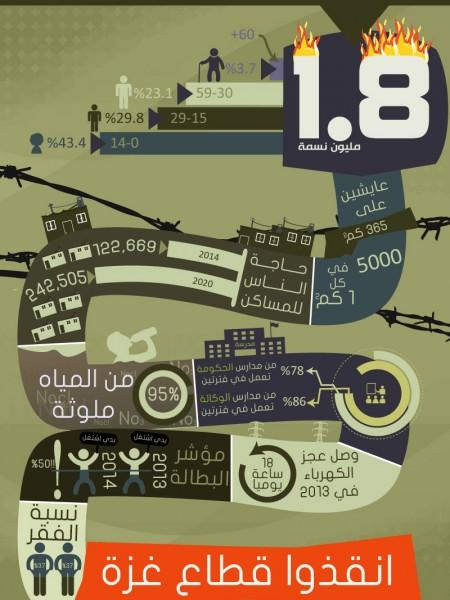

In [55]:
prompt = (
    prompt_format
    .replace("<system_prompt>", SYSTEM_PROMPT)
    .replace("<image>", f"![]({encode_local_image(image_path)})")
    .replace("<user>", question)
)
prompt

In [56]:
API_URL = "https://k2wsvon7w5w37aeb.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()


output = query({
	"inputs": prompt,
	"parameters": {
		"return_full_text": False,
	}
})

In [ ]:
output